# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
display(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [3]:
# Пропущенные значения в столбце Tenure заменю на ноль. 
# Думаю пропущенные значения появились так как клиент или недавно открыл счет, или пользуется меньше года.
df['Tenure'] = df['Tenure'].fillna(0)

In [4]:
df_ohe = pd.get_dummies(df, drop_first=True) # прямое кодирование признаков с использованием дамми ловушек
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

features

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,619,42,2.0,0.00,1,1,1,101348.88,...,0,0,0,0,0,0,0,0,0,0
1,2,15647311,608,41,1.0,83807.86,1,0,1,112542.58,...,0,0,0,0,0,0,0,0,1,0
2,3,15619304,502,42,8.0,159660.80,3,1,0,113931.57,...,0,0,0,0,0,0,0,0,0,0
3,4,15701354,699,39,1.0,0.00,2,0,0,93826.63,...,0,0,0,0,0,0,0,0,0,0
4,5,15737888,850,43,2.0,125510.82,1,1,1,79084.10,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,771,39,5.0,0.00,2,1,0,96270.64,...,0,0,0,0,0,0,0,0,0,1
9996,9997,15569892,516,35,10.0,57369.61,1,1,1,101699.77,...,0,0,0,0,0,0,0,0,0,1
9997,9998,15584532,709,36,7.0,0.00,1,0,1,42085.58,...,0,0,0,0,0,0,0,0,0,0
9998,9999,15682355,772,42,3.0,75075.31,2,1,0,92888.52,...,0,0,0,0,0,0,0,1,0,1


In [5]:
# отделил обучающаую выборку, взял 75%
features_train, features_rest, target_train, target_rest = train_test_split(features, target, test_size=0.25, random_state=12345)

# отделил валидационную и тестовую выборки 50/50
features_test, features_valid, target_test, target_valid = train_test_split(features_rest, target_rest, test_size=0.5, random_state=12345)

In [6]:
# маштабирую количественные признаки
numeric = ['RowNumber','CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'CustomerId']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_158/771139264.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_158/771139264.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [7]:
features_train.head(10)

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
226,-1.642934,1.153912,0.442805,-0.841274,1.426885,-1.224577,0.817772,0.644278,0.959999,-1.269750,...,0,0,0,0,0,0,0,0,0,0
7756,0.961172,-1.180135,-0.310897,-0.270730,0.784858,0.641783,-0.896874,0.644278,0.959999,0.960396,...,0,0,0,0,0,0,0,0,1,0
2065,-1.006951,-1.518692,-0.259274,-0.556002,1.105871,-1.224577,0.817772,0.644278,-1.041667,0.661864,...,0,0,0,0,0,0,0,0,0,1
2800,-0.752766,-0.616822,1.217157,1.155631,1.426885,1.290462,0.817772,0.644278,-1.041667,-1.039476,...,0,0,0,0,0,0,0,0,0,1
7028,0.709407,-1.011106,0.690598,-1.221637,-1.462240,1.142121,-0.896874,-1.552125,-1.041667,-0.851729,...,0,0,0,0,0,0,0,1,0,1
6894,0.663066,0.224629,0.401507,-1.221637,1.105871,0.641455,-0.896874,0.644278,0.959999,-0.294925,...,0,0,0,0,0,0,0,0,1,1
4226,-0.259611,0.859965,-0.001156,-0.270730,1.105871,-1.224577,0.817772,0.644278,-1.041667,-0.149472,...,0,0,0,0,0,0,0,0,1,0
5857,0.304439,1.698917,-0.589664,1.631085,-1.462240,-1.224577,-0.896874,0.644278,-1.041667,-1.282642,...,0,0,0,0,0,0,0,0,0,0
142,-1.671984,-0.875986,0.318909,0.394906,0.142830,0.794399,-0.896874,0.644278,0.959999,1.611082,...,0,0,0,0,0,0,0,0,0,0
7107,0.736727,1.056267,0.618325,0.585087,-1.141226,0.339342,0.817772,0.644278,-1.041667,-0.860196,...,0,0,0,0,0,0,0,1,0,0


#### Вывод

Провел прямое кодирование признаков с использованием дамми ловушек.

Разделил данные на три выборки: обучающую, валидационную и тестовую

Маштабировал количественные признаки в списке numeric

## Исследование задачи

In [8]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train) 
predictions_valid = model.predict(features_valid) 
f1_score(target_valid, predictions_valid)


0.5370741482965932

In [9]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train) 
predictions_valid = model.predict(features_valid) 
f1_score(target_valid, predictions_valid)

0.4751958224543081

In [10]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.3210526315789474


#### Вывод

Получил на разных трех моделях показатель f1. Во всех трех моделях показатель меньше 0,59. Буду улучшать модель дальше.


## Борьба с дисбалансом

In [11]:
# увеличим выборку
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [12]:
target_upsampled.value_counts(normalize=True)

1    0.500416
0    0.499584
Name: Exited, dtype: float64

Выравнил баланс

In [13]:
# подберем лучшие показатели max_depth
best_f1 = 0
best_depth = 0
for i in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=i, class_weight='balanced')
    model.fit(features_upsampled, target_upsampled) 
    predictions_valid = model.predict(features_valid) 
    f1 = f1_score(target_valid, predictions_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = i
print("Лучший f1:", best_f1)
print("Лучший max_depth:", best_depth)

Лучший f1: 0.6016
Лучший max_depth: 5


Модель дерева решений, показала наилучший результат f1 = 0.6 с параметром max_depth= 5

In [15]:
# подберем лучший параметр для модели случайный лес

best_model_forest = None
best_f1_forest = 0
best_est_forest = 0
best_depth_forest = 0
for depth in range (1, 16):
    for est in range(1,101, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        f1_predict = f1_score(target_valid, predicted_valid)
        if f1_predict > best_f1_forest:
            best_model_forest = model
            best_f1_forest = f1_predict
            best_est_forest = est
            best_depth_forest = depth
        
        
        
print("F1, случайный лес -", float('{:.3f}'.format(best_f1_forest)))
probabilities_valid = best_model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("AUC-ROC - ", float('{:.3f}'.format(roc_auc_score(target_valid, probabilities_one_valid))))

F1, случайный лес - 0.571
AUC-ROC -  0.796


Модель случайного дерева, показала наилучший результат f1 = 0.571 при  n_estimators=49

In [16]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight = 'balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4424514200298954


Модель логической регрессии показала худший результат

In [17]:
# уменьшим выборку
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
1
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_downsampled, target_downsampled) 
predictions_valid = model.predict(features_valid) 

print("F1:", f1_score(target_valid, predictions_valid))

F1: 0.595108695652174


In [18]:
target_downsampled.value_counts(normalize=True)

1    0.500333
0    0.499667
Name: Exited, dtype: float64

После выравнивания баланса показатель улучшился до 0,59

## Вывод

Модель дерева решений, показала наилучший результат f1 = 0.6 с параметром max_depth= 5

## Тестирование модели

Тестирование модели буду проводить на модели дерева решений, с параметром max_depth= 5

In [19]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_upsampled, target_upsampled) 
predictions_test = model.predict(features_test) 
f1_score(target_test, predictions_test)

0.5977011494252874

Показатель выше 0.59

In [20]:
model = DecisionTreeClassifier(random_state=12345, max_depth=5, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_test)
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid)

print(auc_roc)

0.8427350229793399


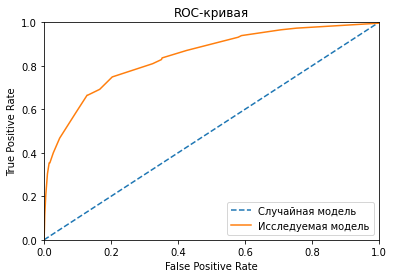

In [21]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend(['Случайная модель', 'Исследуемая модель'], loc=0)

plt.show()

#### вывод:

На тестовой выборке модель дерева решений показала результат f1 = 0.6
Показатель auc_roc = 0.84, приблизился к 1.

# Общий вывод

Провел исследование оттока клиентов из банка. 
Построил модели и выбрал наилучшую модель, которая показала лучшиие результаты на валидационной выборке. Проверил на тестовой выборке, результат F1 был 0.6. Показатель auc_roc = 0.84. 